# Create Modeling and Credit Scorecard From scorecardpy Package

About `scorecardpy`:<br>
The goal of scorecard package is to make the development of the traditional credit risk scorecard model easier and efficient by providing functions for some common tasks that summarized in below.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import scorecardpy as sc
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, auc, confusion_matrix
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 200)

In [2]:
data = pd.read_csv("df_preprocessing.csv")

In [3]:
dt_s = sc.var_filter(data, y='TARGET',var_rm=['SK_ID_CURR','REG_CITY_NOT_WORK_CITY','REG_CITY_NOT_LIVE_CITY'],var_kp = ['FLAG_PHONE','CNT_CHILDREN','FLAG_OWN_CAR','NAME_FAMILY_STATUS'])

[INFO] filtering variables ...
Variable filtering on 252137 rows and 37 columns in 00:02:48 
14 variables are removed


In [4]:
dt_s.head()

,AGE,AMT_ANNUITY,AMT_CREDIT,AMT_GOODS_PRICE,AMT_INCOME_TOTAL,CNT_CHILDREN,CODE_GENDER,EMP_LENGTH,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,FLAG_OWN_CAR,FLAG_PHONE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_INCOME_TYPE,OCCUPATION_TYPE,PHONE_CHANGE_LENGTH,PUBLISH_LENGTH,REGION_POPULATION_RELATIVE,REGION_RATING_CLIENT,REGIST_LENGTH,TARGET
0,26.0,24700.5,406597.5,351000.0,202500.0,0,1,2.0,0.083037,0.262949,0.139376,0,1,Secondary / secondary special,Single / not married,Working,Labour Job,3.0,6.0,0.018801,2,10.0,1
1,46.0,35698.5,1293502.5,1129500.0,270000.0,0,0,3.0,0.311267,0.622246,0.000000,0,1,Higher education,Married,State servant,Office Job,2.0,1.0,0.003541,1,3.0,0
2,52.0,6750.0,135000.0,135000.0,67500.0,0,1,1.0,0.000000,0.555912,0.729567,1,1,Secondary / secondary special,Single / not married,Working,Labour Job,2.0,7.0,0.010032,2,12.0,0
3,52.0,29686.5,312682.5,297000.0,135000.0,0,0,8.0,0.000000,0.650442,0.000000,0,0,Secondary / secondary special,Married,Working,Labour Job,2.0,7.0,0.008019,2,27.0,0
4,55.0,21865.5,513000.0,513000.0,121500.0,0,1,8.0,0.000000,0.322738,0.000000,0,0,Secondary / secondary special,Single / not married,Working,Office Job,3.0,9.0,0.028663,2,12.0,0


[INFO] creating woe binning ...
Binning on 252137 rows and 23 columns in 00:00:21


{'REGION_POPULATION_RELATIVE': <Figure size 432x288 with 2 Axes>,
 'PUBLISH_LENGTH': <Figure size 432x288 with 2 Axes>,
 'EXT_SOURCE_3': <Figure size 432x288 with 2 Axes>,
 'EXT_SOURCE_2': <Figure size 432x288 with 2 Axes>,
 'OCCUPATION_TYPE': <Figure size 432x288 with 2 Axes>,
 'CODE_GENDER': <Figure size 432x288 with 2 Axes>,
 'REGIST_LENGTH': <Figure size 432x288 with 2 Axes>,
 'AMT_ANNUITY': <Figure size 432x288 with 2 Axes>,
 'REGION_RATING_CLIENT': <Figure size 432x288 with 2 Axes>,
 'NAME_FAMILY_STATUS': <Figure size 432x288 with 2 Axes>,
 'NAME_EDUCATION_TYPE': <Figure size 432x288 with 2 Axes>,
 'PHONE_CHANGE_LENGTH': <Figure size 432x288 with 2 Axes>,
 'AMT_CREDIT': <Figure size 432x288 with 2 Axes>,
 'FLAG_PHONE': <Figure size 432x288 with 2 Axes>,
 'CNT_CHILDREN': <Figure size 432x288 with 2 Axes>,
 'FLAG_OWN_CAR': <Figure size 432x288 with 2 Axes>,
 'AMT_GOODS_PRICE': <Figure size 432x288 with 2 Axes>,
 'EXT_SOURCE_1': <Figure size 432x288 with 2 Axes>,
 'EMP_LENGTH': <Fig

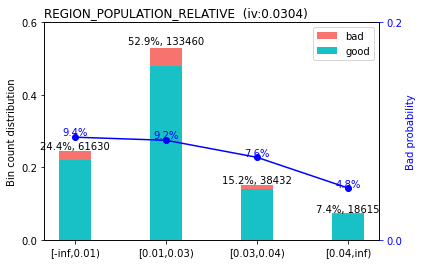

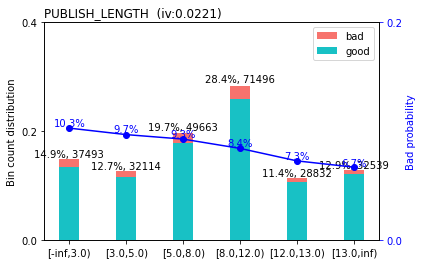

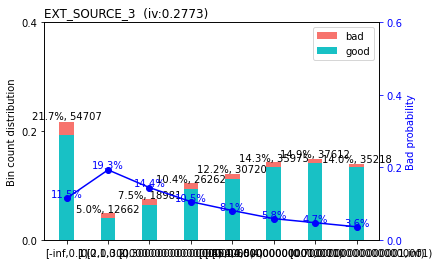

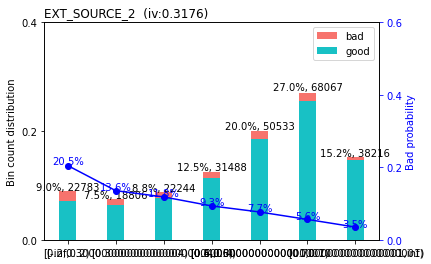

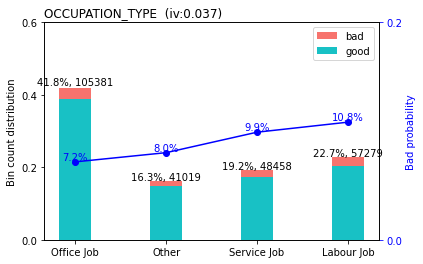

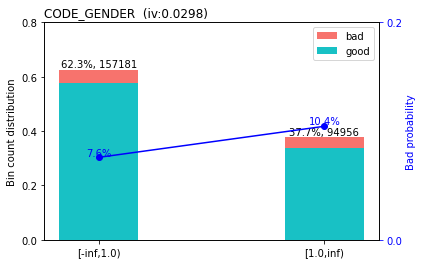

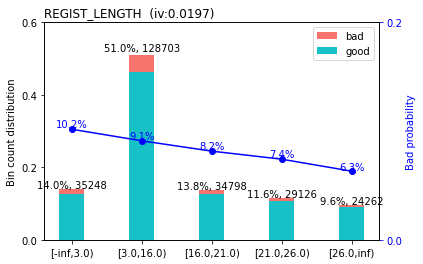

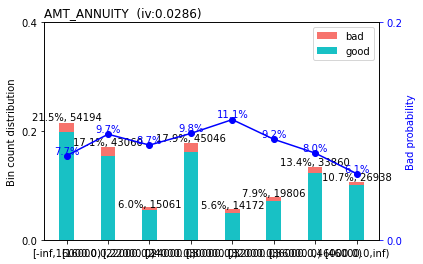

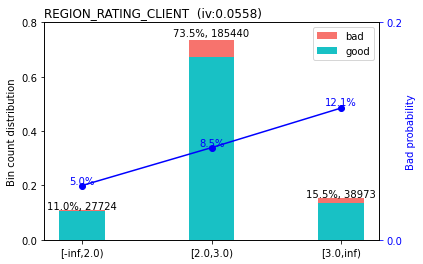

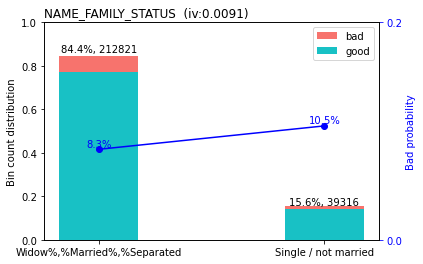

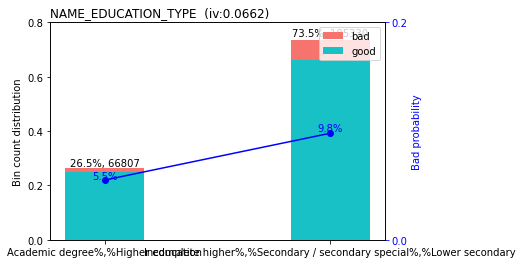

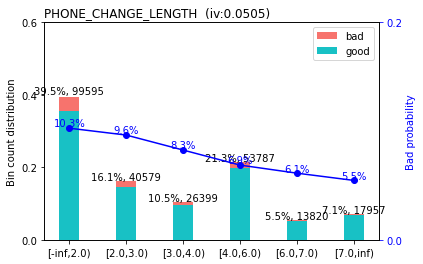

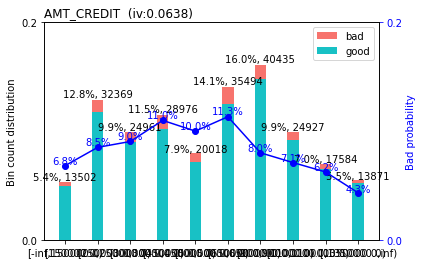

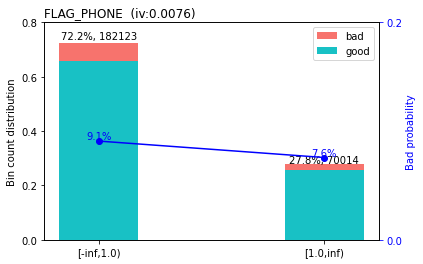

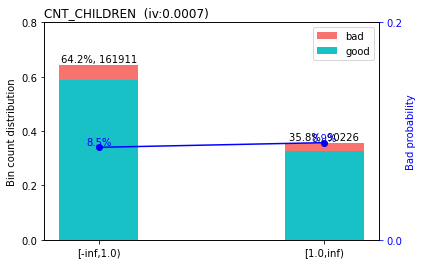

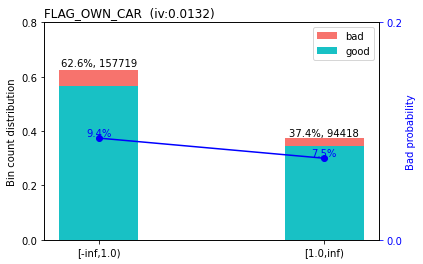

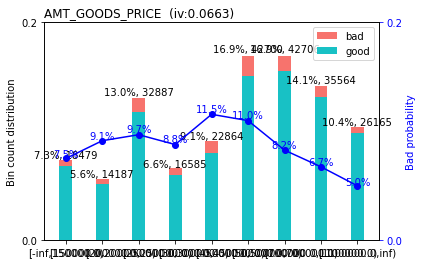

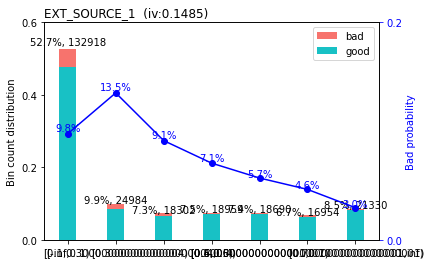

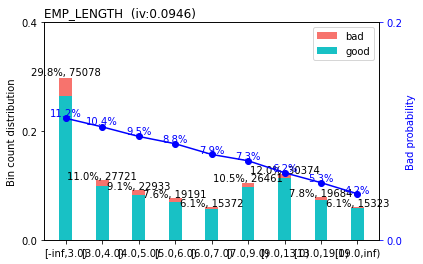

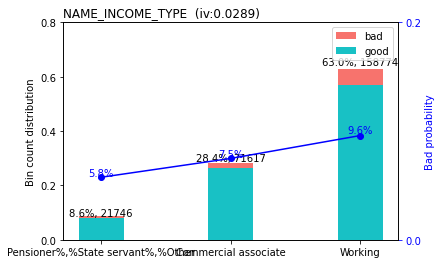

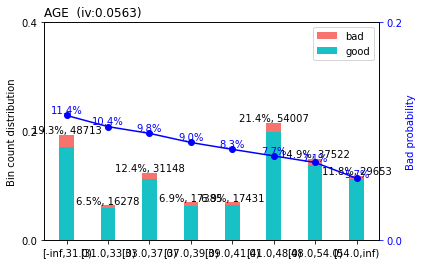

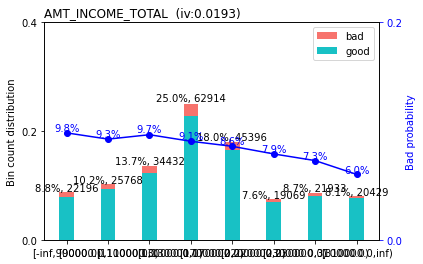

In [5]:
bins = sc.woebin(dt_s, y="TARGET",bin_num_limit=10,method = "chimerge")
sc.woebin_plot(bins)

In [6]:
train, test = sc.split_df(dt_s, 'TARGET',ratio = 0.7,seed = 24).values()

In [7]:
# converting train and test into woe values
train_woe = sc.woebin_ply(train, bins = bins)
test_woe = sc.woebin_ply(test, bins = bins)
y_train = train_woe.loc[:,'TARGET']
X_train = train_woe.loc[:,train_woe.columns != 'TARGET']
y_test = test_woe.loc[:,'TARGET']
X_test = test_woe.loc[:,train_woe.columns != 'TARGET']

[INFO] converting into woe values ...
[INFO] converting into woe values ...


In [8]:
from imblearn.over_sampling import SMOTE 

In [9]:
# Handle Imbalance Target Using SMOTE
sm = SMOTE(random_state=24)
sm.fit(X_train, y_train)
X_smote, y_smote = sm.fit_resample(X_train, y_train)
X_smote.shape, X_train.shape, y_smote.shape, y_train.shape

((322422, 22), (176495, 22), (322422,), (176495,))

# Modeling

In [10]:
param = {
    'penalty' : ['none', 'l2', 'l1', 'elasticnet'],
    'C' : [float(x) for x in np.linspace(start=0, stop=1, num=75)],
    'solver' : ['lbfgs','saga','liblinear']
     }

logreg = LogisticRegression()

# search
logreg_clf = RandomizedSearchCV(logreg,
                            param,
                            scoring='roc_auc',
                            cv=5,
                            random_state = 24) 

search_logreg = logreg_clf.fit(X_smote,y_smote)
# best hyperparameters
search_logreg.best_params_

{'solver': 'lbfgs', 'penalty': 'none', 'C': 0.8108108108108109}

In [11]:
best_params = search_logreg.best_params_
logreg_tuning = LogisticRegression(**best_params)
logreg_tuning.fit(X_smote,y_smote)

LogisticRegression(C=0.8108108108108109, penalty='none')

In [12]:
# predicted proability
train_pred = logreg_tuning.predict_proba(X_train)[:,1]
test_pred = logreg_tuning.predict_proba(X_test)[:,1]

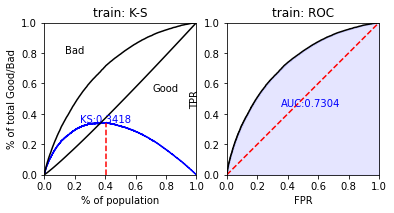

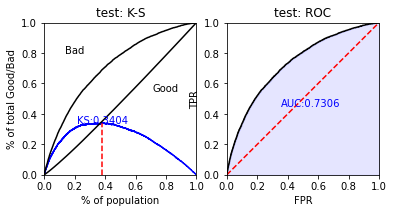

In [13]:
# performance ks & roc ------
train_perf = sc.perf_eva(y_train, train_pred, title = "train")
test_perf = sc.perf_eva(y_test, test_pred, title = "test")

In [14]:
# score ------
card = sc.scorecard(bins,logreg_tuning, X_train.columns)
# credit score
train_score = sc.scorecard_ply(train, card, print_step=0)
test_score = sc.scorecard_ply(test, card, print_step=0)

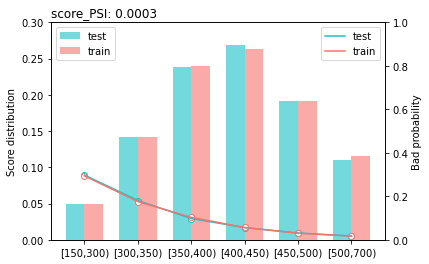

{'psi':   variable       PSI
 0    score  0.000326,
 'pic': {'score': <Figure size 432x288 with 2 Axes>}}

In [15]:
# psi
sc.perf_psi(
  score = {'train':train_score, 'test':test_score},
  label = {'train':y_train, 'test':y_test}
)

In [16]:
def score_bin_sort(score, label=None, title=None, x_limits=None, x_tick_break=50, seed=186):
    # inputs checking
    ## score
    if not isinstance(score, dict) and len(score) != 2:
        raise Exception("Incorrect inputs; score should be a dictionary with two elements.")
    else:
        if any([not isinstance(i, pd.DataFrame) for i in score.values()]):
            raise Exception("Incorrect inputs; score is a dictionary of two dataframes.")
        score_columns = [list(i.columns) for i in score.values()]
        if set(score_columns[0]) != set(score_columns[1]):
            raise Exception("Incorrect inputs; the column names of two dataframes in score should be the same.")
    ## label
    if label is not None:
        if not isinstance(label, dict) and len(label) != 2:
            raise Exception("Incorrect inputs; label should be a dictionary with two elements.")
        else:
            if set(score.keys()) != set(label.keys()):
                raise Exception("Incorrect inputs; the keys of score and label should be the same. ")
            for i in label.keys():
                if isinstance(label[i], pd.DataFrame):
                    if len(label[i].columns) == 1:
                        label[i] = label[i].iloc[:,0]
                    else:
                        raise Exception("Incorrect inputs; the number of columns in label should be 1.")
    # score dataframe column names
    score_names = score[list(score.keys())[0]].columns
    # merge label with score
    for i in score.keys():
        score[i] = score[i].copy(deep=True)
        if label is not None:
            score[i].loc[:,'y'] = label[i]
        else:
            score[i].copy(deep=True).loc[:,'y'] = np.nan
    # dateset of score and label
    dt_sl = pd.concat(score, names=['ae', 'rowid']).reset_index()\
      .sample(frac=1, random_state=seed)
      # ae refers to 'Actual & Expected'
    # PSI function
    def psi(dat):
        dt_bae = dat.groupby(['ae','bin']).size().reset_index(name='N')\
          .pivot_table(values='N', index='bin', columns='ae').fillna(0.9)\
          .agg(lambda x: x/sum(x))
        dt_bae.columns = ['A','E']
        psi_dt = dt_bae.assign(
          AE = lambda x: x.A-x.E,
          logAE = lambda x: np.log(x.A/x.E)
        ).assign(
          bin_PSI=lambda x: x.AE*x.logAE
        )['bin_PSI'].sum()
        return psi_dt
    
    # return psi and pic
    rt_psi = {}
    rt_pic = {}
    rt_dat = {}
    rt = {}
    for sn in score_names:
        # dataframe with columns of ae y sn
        dat = dt_sl[['ae', 'y', sn]]
        if len(dt_sl[sn].unique()) > 10:
            # breakpoints
            if x_limits is None:
                x_limits = dat[sn].quantile([0.02, 0.98])
                x_limits = round(x_limits/x_tick_break)*x_tick_break
                x_limits = list(x_limits)
        
            brkp = np.unique([np.floor(min(dt_sl[sn])/x_tick_break)*x_tick_break]+\
              list(np.arange(x_limits[0], x_limits[1], x_tick_break))+\
              [np.ceil(max(dt_sl[sn])/x_tick_break)*x_tick_break])
            # cut
            labels = ['[{},{})'.format(int(brkp[i]), int(brkp[i+1])) for i in range(len(brkp)-1)]
            dat.loc[:,'bin'] = pd.cut(dat[sn], brkp, right=False, labels=labels)
        else:
            dat.loc[:,'bin'] = dat[sn]
        # psi ------
        rt_psi[sn] = pd.DataFrame({'PSI':psi(dat)},index=np.arange(1)) 
    
        # distribution of scorecard probability
        def good(x): return sum(x==0)
        def bad(x): return sum(x==1)
        distr_prob = dat.groupby(['ae', 'bin'])\
          ['y'].agg([good, bad])\
          .assign(N=lambda x: x.good+x.bad,
            badprob=lambda x: x.bad/(x.good+x.bad)
          ).reset_index()
        distr_prob.loc[:,'distr'] = distr_prob.groupby('ae')['N'].transform(lambda x:x/sum(x))
        # pivot table
        distr_prob = distr_prob.pivot_table(values=['N','badprob', 'distr'], index='bin', columns='ae')
        rt_dat[sn] = distr_prob[['N','badprob']].reset_index()
        score_bin_sort = pd.DataFrame()
        score_bin_sort['score'] = rt_dat[sn]['bin']
        score_bin_sort['total'] = rt_dat[sn][('N','test')]+rt_dat[sn][('N','train')]
        score_bin_sort['good'] = (rt_dat[sn][('N','test')]*(1-rt_dat[sn][('badprob','test')])+rt_dat[sn][('N','train')]*(1-rt_dat[sn][('badprob','train')])).map(lambda x: int(x))
        score_bin_sort['bad'] = (rt_dat[sn][('N','test')]*rt_dat[sn][('badprob','test')]+rt_dat[sn][('N','train')]*rt_dat[sn][('badprob','train')]).map(lambda x: int(x))
        score_bin_sort['bad rate%'] = (score_bin_sort['bad']/score_bin_sort['total']*100).map(lambda x: int(x))
        score_bin_sort['bin'] = score_bin_sort.index.values
        score_bin_sort = score_bin_sort[['bin','score','total','good','bad','bad rate%']]
    return score_bin_sort

In [17]:
score_bin_sort = score_bin_sort(
    score = {'train':train_score, 'test':test_score},
    label = {'train':y_train, 'test':y_test}
)
score_bin_sort.sort_values(by='bad rate%',ascending=False).style.bar(color='tomato',subset='bad rate%')

,bin,score,total,good,bad,bad rate%
0,0,"[150,300)",12364,8719,3645,29
1,1,"[300,350)",35686,29360,6326,17
2,2,"[350,400)",60444,54307,6137,10
3,3,"[400,450)",66787,63018,3769,5
4,4,"[450,500)",48151,46687,1464,3
5,5,"[500,700)",28705,28211,494,1


In [20]:
import re
## Coefficients in scorecard ##
def ab(points0=600, odds0=1/19, pdo=50):
    # sigmoid function
    # library(ggplot2)
    # ggplot(data.frame(x = c(-5, 5)), aes(x)) + stat_function(fun = function(x) 1/(1+exp(-x)))
  
    # log_odds function
    # ggplot(data.frame(x = c(0, 1)), aes(x)) + stat_function(fun = function(x) log(x/(1-x)))
  
    # logistic function
    # p(y=1) = 1/(1+exp(-z)),
        # z = beta0+beta1*x1+...+betar*xr = beta*x
    ##==> z = log(p/(1-p)),
        # odds = p/(1-p) # bad/good <==>
        # p = odds/1+odds
    ##==> z = log(odds)
    ##==> score = a - b*log(odds)
  
    # two hypothesis
    # points0 = a - b*log(odds0)
    # points0 - PDO = a - b*log(2*odds0)
    # if pdo > 0:
    #     b = pdo/np.log(2)
    # else:
    #     b = -pdo/np.log(2)
    b = pdo/np.log(2)
    a = points0 + b*np.log(odds0) #log(odds0/(1+odds0))
    return {'a':a, 'b':b}


## Creating a scorecard ##
def scorecard(bins, model, xcolumns, points0=600, odds0=1/19, pdo=50, basepoints_eq0=False, digits=0):
    '''
    Creating a Scorecard
    ------
    `scorecard` creates a scorecard based on the results from `woebin` and LogisticRegression of sklearn.linear_model
    
    Params
    ------
    bins:Binning information generated from `woebin` function.
    model:A LogisticRegression model object.
    points0:Target points, default 600.
    odds0:Target odds, default 1/19. Odds = p/(1-p).
    pdo:Points to Double the Odds, default 50.
    basepoints_eq0:Logical, default is FALSE. If it is TRUE, the basepoints will equally distribute to each variable.
    digits:The number of digits after the decimal point for points calculation. Default 0.
    
    Returns
    ------
    DataFrame of scorecard
    
    Examples
    ------
    import scorecardpy as sc
    
    # load data
    data_gc = pd.read_csv('../input/german-credit-data-with-risk/german_credit_data.csv',index_col=0)    

    # filter variable via missing rate, iv, identical value rate
    dt_sel = sc.var_filter(data_gc, "Risk")
    
    # woe binning ------
    bins = sc.woebin(dt_sel, "Risk")
    dt_woe = sc.woebin_ply(dt_sel, bins)
    
    y = dt_woe.loc[:,'Risk']
    X = dt_woe.loc[:,dt_woe.columns != 'Risk']
    
    # logistic regression ------
    from sklearn.linear_model import LogisticRegression
    lr = LogisticRegression(penalty='l1', C=0.9, solver='saga')
    lr.fit(X, y)
    
    # # predicted proability
    # dt_pred = lr.predict_proba(X)[:,1]
    # # performace
    # # ks & roc plot
    # sc.perf_eva(y, dt_pred)
    
    # scorecard
    # Example I # creat a scorecard
    card = sc.scorecard(bins, lr, X.columns)
    
    # credit score
    # Example I # only total score
    score1 = sc.scorecard_ply(dt_sel, card)
    # Example II # credit score for both total and each variable
    score2 = sc.scorecard_ply(dt_sel, card, only_total_score = False)
    '''
    # coefficients
    aabb = ab(points0, odds0, pdo)
    a = aabb['a'] 
    b = aabb['b']
    # odds = pred/(1-pred); score = a - b*log(odds)
    
    # bins # if (is.list(bins)) rbindlist(bins)
    if isinstance(bins, dict):
        bins = pd.concat(bins, ignore_index=True)
    xs = [re.sub('_woe$', '', i) for i in xcolumns]
    # coefficients
    coef_df = pd.Series(model.coef_[0], index=np.array(xs))\
      .loc[lambda x: x != 0]#.reset_index(drop=True)
    
    # scorecard
    len_x = len(coef_df)
    basepoints = a - b*model.intercept_[0]
    card = {}
    if basepoints_eq0:
        card['basepoints'] = pd.DataFrame({'variable':"basepoints", 'bin':np.nan, 'points':0}, index=np.arange(1))
        for i in coef_df.index:
            card[i] = bins.loc[bins['variable']==i,['variable', 'bin', 'woe']]\
              .assign(points = lambda x: round(-b*x['woe']*coef_df[i] + basepoints/len_x), ndigits=digits)\
              [["variable", "bin", "points","woe"]]
    else:
        card['basepoints'] = pd.DataFrame({'variable':"basepoints", 'bin':np.nan, 'points':round(basepoints, ndigits=digits)}, index=np.arange(1))
        for i in coef_df.index:
            card[i] = bins.loc[bins['variable']==i,['variable', 'bin', 'woe']]\
              .assign(points = lambda x: round(-b*x['woe']*coef_df[i]), ndigits=digits)\
              [["variable", "bin", "points","woe"]]
    card_print=pd.DataFrame()
    for i in card.keys():
        card_print=pd.concat([card_print,card[i]],axis=0)
    return card_print


## Apply to Scorecard ##
def scorecard_ply(dt, card, only_total_score=True, print_step=0, replace_blank_na=True, var_kp = None):
    '''
    Score Transformation
    ------
    `scorecard_ply` calculates credit score using the results from `scorecard`.
    
    Params
    ------
    dt:Original data
    card:Scorecard generated from `scorecard`.
    only_total_score:Logical, default is TRUE. If it is TRUE, then the output includes only total credit score; Otherwise, if it is FALSE, the output includes both total and each variable's credit score.
    print_step:A non-negative integer. Default is 1. If print_step>0, print variable names by each print_step-th iteration. If print_step=0, no message is print.
    replace_blank_na:Logical. Replace blank values with NA. Defaults to True. This parameter should be the same with woebin's.
    var_kp:Name of force kept variables, such as id column. Defaults to None.
    
    Return
    ------
    DataFrame of Credit score
    
    Examples
    ------
    import scorecardpy as sc
    
    # load data
    data_gc = pd.read_csv('../input/german-credit-data-with-risk/german_credit_data.csv',index_col=0)    

    # filter variable via missing rate, iv, identical value rate
    dt_sel = sc.var_filter(dat, "Risk")
    
    # woe binning ------
    bins = sc.woebin(dt_sel, "Risk")
    dt_woe = sc.woebin_ply(dt_sel, bins)
    
    y = dt_woe.loc[:,'Risk']
    X = dt_woe.loc[:,dt_woe.columns != 'Risk']
    
    # logistic regression ------
    from sklearn.linear_model import LogisticRegression
    lr = LogisticRegression(penalty='l1', C=0.9, solver='saga')
    lr.fit(X, y)
    
    # # predicted proability
    # dt_pred = lr.predict_proba(X)[:,1]
    # # performace
    # # ks & roc plot
    # sc.perf_eva(y, dt_pred)
    
    # scorecard
    # Example I # creat a scorecard
    card = sc.scorecard(bins, lr, X.columns)
    
    # credit score
    # Example I # only total score
    score1 = sc.scorecard_ply(dt_sel, card)
    # Example II # credit score for both total and each variable
    score2 = sc.scorecard_ply(dt_sel, card, only_total_score = False)
    '''
  
    dt = dt.copy(deep=True)
    # remove date/time col
    # dt = rmcol_datetime_unique1(dt)
    # replace "" by NA
    if replace_blank_na: dt = rep_blank_na(dt)
    # print_step
    print_step = check_print_step(print_step)
    # card # if (is.list(card)) rbindlist(card)
    if isinstance(card, dict):
        card_df = pd.concat(card, ignore_index=True)
    elif isinstance(card, pd.DataFrame):
        card_df = card.copy(deep=True)
    # x variables
    xs = card_df.loc[card_df.variable != 'basepoints', 'variable'].unique()
    # length of x variables
    xs_len = len(xs)
    # initial datasets
    dat = dt.loc[:,list(set(dt.columns)-set(xs))]
    
    # loop on x variables
    for i in np.arange(xs_len):
        x_i = xs[i]
        # print xs
        if print_step>0 and bool((i+1)%print_step): 
            print(('{:'+str(len(str(xs_len)))+'.0f}/{} {}').format(i, xs_len, x_i))
        
        cardx = card_df.loc[card_df['variable']==x_i]
        dtx = dt[[x_i]]
        # score transformation
        dtx_points = woepoints_ply1(dtx, cardx, x_i, woe_points="points")
        dat = pd.concat([dat, dtx_points], axis=1)
    
    # set basepoints
    card_basepoints = list(card_df.loc[card_df['variable']=='basepoints','points'])[0] if 'basepoints' in card_df['variable'].unique() else 0
    # total score
    dat_score = dat[xs+'_points']
    dat_score.loc[:,'score'] = card_basepoints + dat_score.sum(axis=1)
    # dat_score = dat_score.assign(score = lambda x: card_basepoints + dat_score.sum(axis=1))
    # return
    if only_total_score: dat_score = dat_score[['score']]
    
    # check force kept variables
    if var_kp is not None:
        if isinstance(var_kp, str):
            var_kp = [var_kp]
        var_kp2 = list(set(var_kp) & set(list(dt)))
        len_diff_var_kp = len(var_kp) - len(var_kp2)
        if len_diff_var_kp > 0:
            warnings.warn("Incorrect inputs; there are {} var_kp variables are not exist in input data, which are removed from var_kp. \n {}".format(len_diff_var_kp, list(set(var_kp)-set(var_kp2))) )
        var_kp = var_kp2 if len(var_kp2)>0 else None
    if var_kp is not None: dat_score = pd.concat([dt[var_kp], dat_score], axis = 1)
    return dat_score

In [21]:
card_1 = scorecard(bins, logreg_tuning, X_train.columns)
card_1.sort_values("points",ascending = False)

,variable,bin,points,woe
0,basepoints,NaN,389.0,NaN
17,EXT_SOURCE_3,"[0.7000000000000001,inf)",56.0,-0.934028
24,EXT_SOURCE_2,"[0.7000000000000001,inf)",49.0,-0.958241
88,EXT_SOURCE_1,"[0.7000000000000001,inf)",45.0,-1.136292
16,EXT_SOURCE_3,"[0.6000000000000001,0.7000000000000001)",39.0,-0.650486
97,EMP_LENGTH,"[19.0,inf)",33.0,-0.762522
15,EXT_SOURCE_3,"[0.5,0.6000000000000001)",26.0,-0.424357
87,EXT_SOURCE_1,"[0.6000000000000001,0.7000000000000001)",26.0,-0.667955
23,EXT_SOURCE_2,"[0.6000000000000001,0.7000000000000001)",24.0,-0.465498
96,EMP_LENGTH,"[13.0,19.0)",23.0,-0.535514


In [22]:
credit_score= card_1.sort_values('points',ascending = False)

In [23]:
credit_score = credit_score.iloc[1:, :]

In [24]:
credit_score['feature'] = credit_score['variable'] +'_'+credit_score['bin']

Text(0.5, 1.0, 'Score Card Each Features')

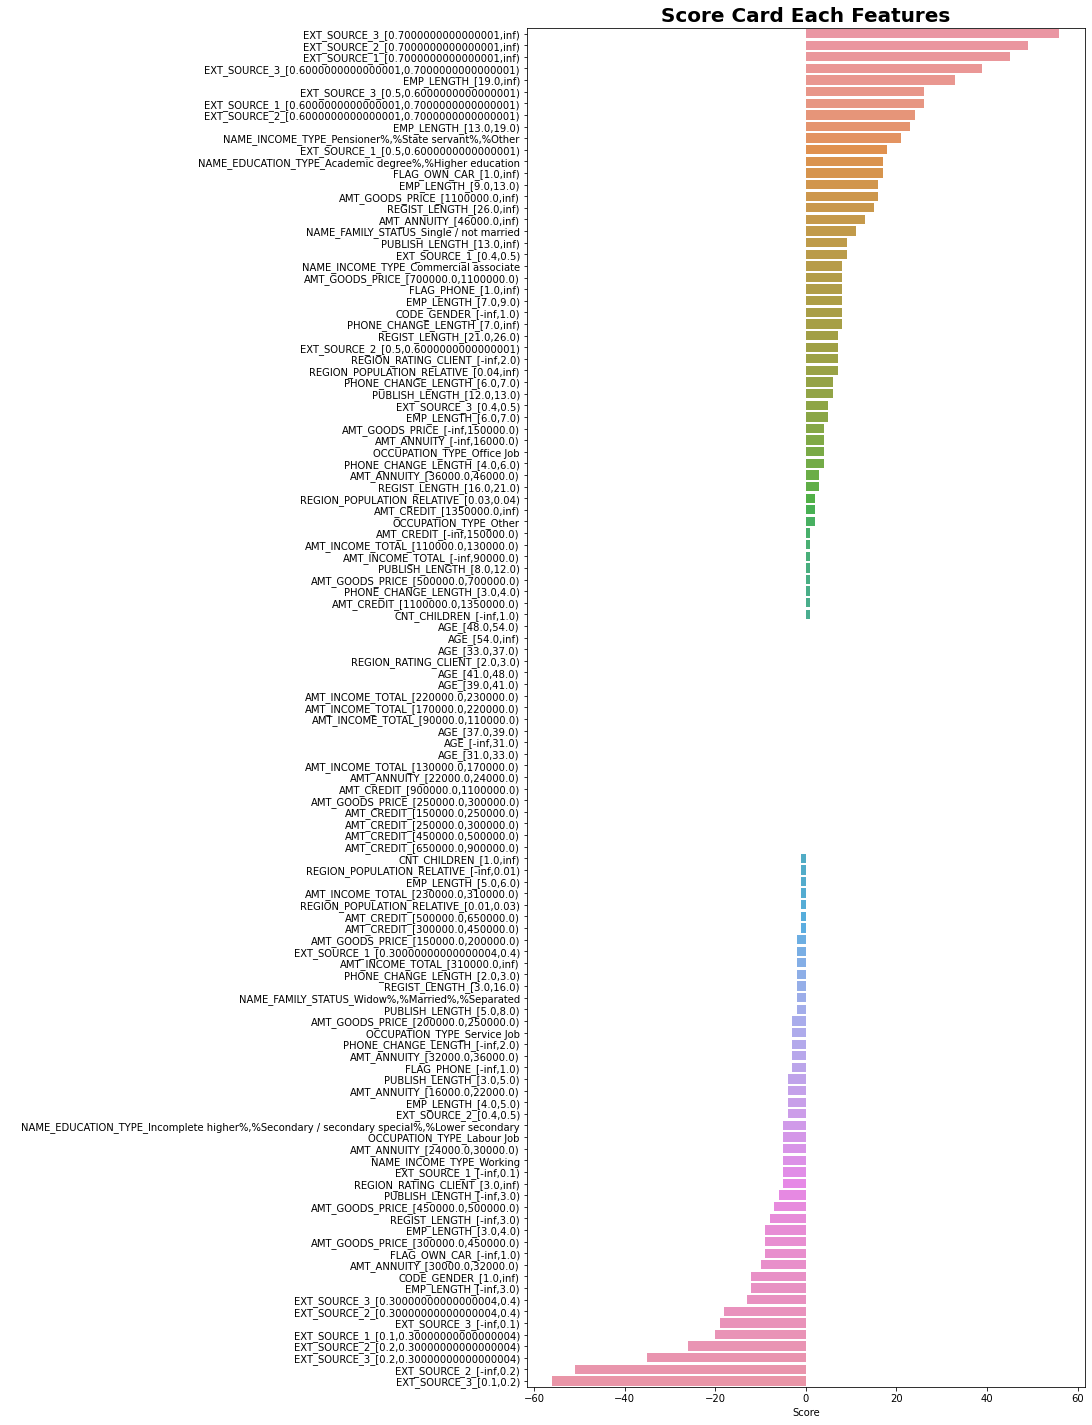

In [25]:
fig, ax = plt.subplots(figsize=(10, 25))
sns.barplot(x='points', y='feature', data=credit_score)
plt.ylabel(' ')
plt.xlabel('Score')
plt.title('Score Card Each Features', fontsize=20, weight='extra bold')

## Insight

In [26]:
df_score = sc.scorecard_ply(data, card, print_step=0)

In [27]:
credit_score_w_id = pd.merge(data, df_score, left_index = True, right_index = True)

In [28]:
credit_score_w_id['NAME_INCOME_TYPE'].value_counts()

Working                 158774
Commercial associate     71617
State servant            21703
Other                       33
Pensioner                   10
Name: NAME_INCOME_TYPE, dtype: int64

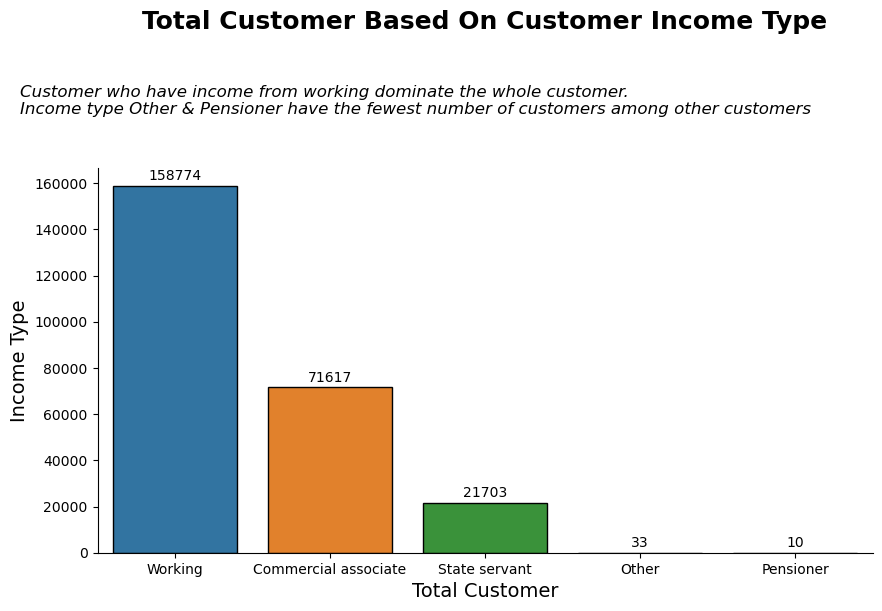

In [30]:
# Number Customer Income Type
income_type_vis = credit_score_w_id.groupby('NAME_INCOME_TYPE').agg(num_customer = ('SK_ID_CURR','count')).reset_index().sort_values('num_customer',ascending = False)
income_type_vis= income_type_vis.sort_values('num_customer',ascending = False)

# Visualization
plt.style.use('default')
fig, ax = plt.subplots(figsize=(10, 5))
plt.title("Total Customer Based On Customer Income Type", fontsize=18, color='black', weight='bold',pad = 100)
plt.text(x=-1, y=190000, s="Customer who have income from working dominate the whole customer.\nIncome type Other & Pensioner have the fewest number of customers among other customers",
         fontsize=12, fontstyle='italic')
sns.barplot(x='NAME_INCOME_TYPE', y='num_customer', data=income_type_vis, edgecolor='black')
plt.bar_label(ax.containers[0], padding=2)
plt.xlabel('Total Customer', fontsize=14)
plt.ylabel('Income Type', fontsize=14)
sns.despine()

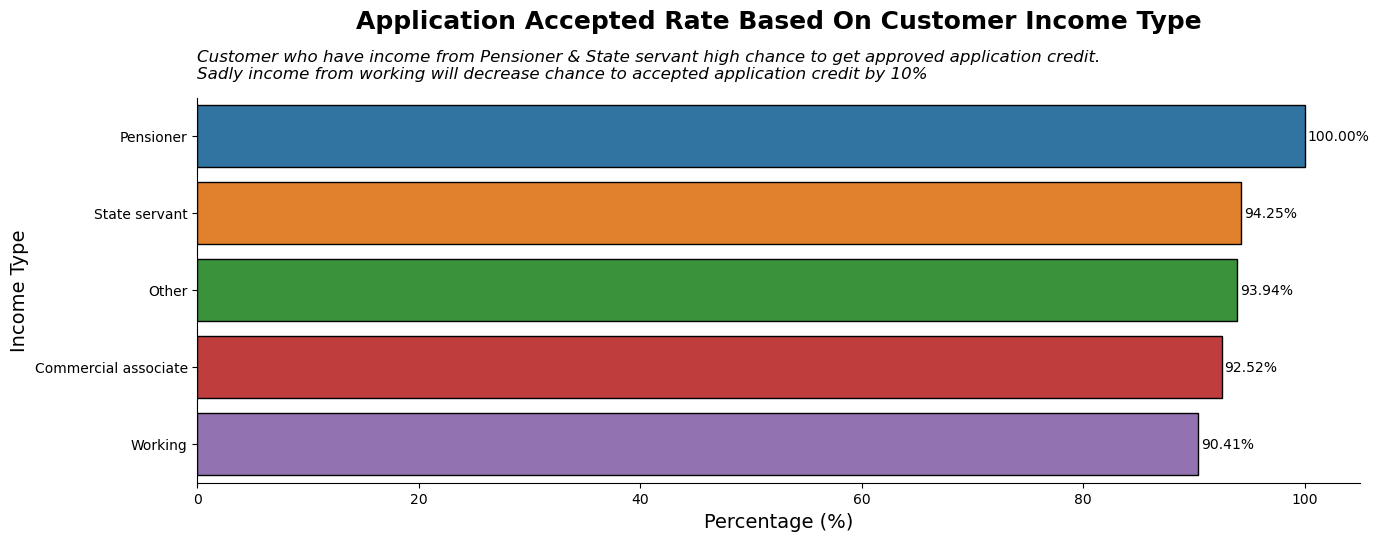

In [33]:
app_acc_income_type = credit_score_w_id.groupby(['NAME_INCOME_TYPE','TARGET']).agg(num_customer = ('SK_ID_CURR','count')).reset_index()
total_cust = app_acc_income_type.groupby('NAME_INCOME_TYPE').agg(total_customer = ('num_customer','sum')).reset_index()
app_acc_income_type_merge = app_acc_income_type.merge(total_cust,on = ['NAME_INCOME_TYPE'])
app_acc_income_type_merge['percentage'] = round(app_acc_income_type_merge['num_customer']/app_acc_income_type_merge['total_customer']*100, 2)
app_acc_income_type_merge = app_acc_income_type_merge.sort_values('percentage',ascending = False)
result_groupby_acc = app_acc_income_type_merge[(app_acc_income_type_merge['TARGET'] == 0)]

plt.style.use('default')
fig, ax = plt.subplots(figsize=(15, 5))
plt.title("Application Accepted Rate Based On Customer Income Type", fontsize=18, color='black', weight='bold',pad = 50)
plt.text(x=0, y=-0.75, s="Customer who have income from Pensioner & State servant high chance to get approved application credit.\nSadly income from working will decrease chance to accepted application credit by 10%",
         fontsize=12, fontstyle='italic')
sns.barplot(y='NAME_INCOME_TYPE', x='percentage', data=result_groupby_acc, edgecolor='black')
plt.bar_label(ax.containers[0], padding=2,fmt='%.2f%%')
plt.xlabel('Percentage (%)', fontsize=14)
plt.ylabel('Income Type', fontsize=14)
sns.despine()